In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import sys
sys.path.insert(1, 'scripts/')
from gen_matrix import matrix_gen, get_ICA
from get_sample import get_sample, create_strings_for_dataset
from fft import fft_for_sample
from tqdm import tqdm 
%matplotlib inline

In [326]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [283]:
import operator

In [5]:
def generate_simple_dataset(size, pandas=False):
    h, w = size
    v = np.linspace(0.1, 40000, w)
    
    dataset = v
    for i in range(h-1):
        dataset = np.vstack((dataset, v))
        
    if pandas:
        return pd.DataFrame(dataset)
    
    return dataset

def func_for_1class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 5*np.cos(15*pi*t) + 3*np.cos(20*pi*t) + noise

def func_for_2class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 2*np.cos(10*pi*t) + 3*np.cos(20*pi*t) + noise

def func_for_3class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 10*np.cos(20*pi*t) + 3*np.cos(20*pi*t) + noise

def get_cosinus_matrix():
    data_simple = generate_simple_dataset((128, 20000))
    vec = data_simple[65]
    
    size = (128, 20000)
    class_ = size[1]//3
    class1 = [0,class_]
    class2 = [class_,class_*2]
    class3 = [class_*2, data_simple.shape[1]]
    
    vec[class1[0]:class1[1]] = func_for_1class(vec[class1[0]:class1[1]])
    vec[class2[0]:class2[1]] = func_for_2class(vec[class2[0]:class2[1]])
    vec[class3[0]:class3[1]] = func_for_3class(vec[class3[0]:class3[1]])
    
    data_simple[65] = vec
    
    return data_simple

In [8]:
size = (128, 20000)
class_ = size[1]//3


data = get_cosinus_matrix()
ICA = get_ICA()
#Перемножаем ICA и EEG матрицы
matrix = np.matmul(ICA, data)
#Разбиваем на матрицы классов, чтоб проще было делить на семплы
matrix_class1 = matrix[:,0:class_]
matrix_calss2 = matrix[:, class_:class_*2]
matrix_calss3 = matrix[:, class_*2:data.shape[1]]
#Получаем семплы для каждого класса
sample_calss1 = get_sample(matrix_class1)
sample_calss2 = get_sample(matrix_calss2)
sample_calss3 = get_sample(matrix_calss3)
#Преобразование Фурье
samples_fft = list(map(abs, fft_for_sample(sample_calss1 + sample_calss2 + sample_calss3, first_n_elements=20)))

sample_calss1_fft = samples_fft[:34]
sample_calss2_fft = samples_fft[34:34*2]
sample_calss3_fft = samples_fft[34*2:]

#Создание строк для датасета, из матрицы 128*20 -> в вектор 2560
sample_calss1_fft_str = create_strings_for_dataset(sample_calss1_fft)
sample_calss2_fft_str = create_strings_for_dataset(sample_calss2_fft)
sample_calss3_fft_str = create_strings_for_dataset(sample_calss3_fft)

#Создание таблицы объекты-признаки

#Класс 1
data_class_1 = pd.DataFrame(data=np.zeros((34, 2560)))
data_class_1['label'] = 1

for i in tqdm(range(len(sample_calss1_fft_str))):
    data_class_1.loc[i, :-1] = sample_calss1_fft_str[i]
    
    
#Класс 2
data_class_2 = pd.DataFrame(data=np.zeros((34, 2560)))
data_class_2['label'] = 2

for i in tqdm(range(len(sample_calss2_fft_str))):
    data_class_2.loc[i, :-1] = sample_calss2_fft_str[i]
    
    
#Класс 3
data_class_3 = pd.DataFrame(data=np.zeros((34, 2560)))
data_class_3['label'] = 3

for i in tqdm(range(len(sample_calss3_fft_str))):
    data_class_3.loc[i, :-1] = sample_calss3_fft_str[i]
    
    
data = pd.concat([data_class_1, data_class_2, data_class_3], axis=0)
print(data.shape)

100%|██████████| 34/34 [00:14<00:00,  2.24it/s]

(102, 2561)


In [327]:
## Понизим размерность до 60 компонент
PCA = PCA(n_components=60)

#Стандартизируем матрицу
Scaler = StandardScaler()
data_standart = Scaler.fit_transform((data).iloc[:, :-1])
# Понижаем размерность
data_pca = PCA.fit_transform(data_standart)

data_pca = pd.DataFrame(data_pca)

# data_pca['label'] = data['label'].values
labels = data['label'].values

#Посмотрим важные признаки с помощью RF
rf = RandomForestClassifier()
rf.fit(data_pca, labels)

/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

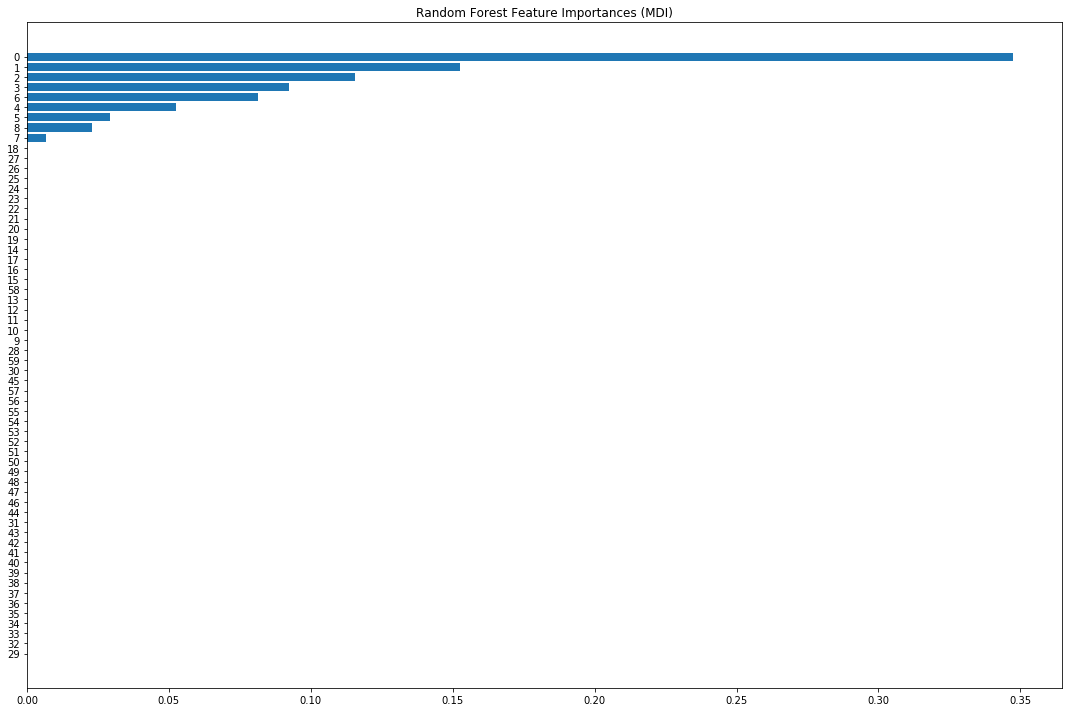

In [363]:
tree_feature_importances = (rf.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(data_pca.columns))
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(data_pca.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.savefig('RF PCA Feature Importances')
plt.show()

In [329]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = data_pca.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [332]:
feature_importances.loc[:5, :]

,importance
0,0.347334
1,0.152703
2,0.115552
3,0.092159
6,0.081289
4,0.052368
5,0.029165


In [334]:
train_features = data_standart
from sklearn.decomposition import PCA
model = PCA(n_components=60).fit(train_features)
X_pc = model.transform(train_features)

features_good = ['0', '1', '2', '3', '6']
features_normal = ['4','5','8','7']
features_bad = list(map(str, np.arange(9, 60)))

In [335]:
def features_imp_pca(train_features, model_pca, X_pca, features_good, features_bad, features_normal):
    reward_best = 50
    reward_max = 10
    reward_med = 5
    reward_min = 1
    
    fe_imp = {}
    for feature in range(0, 2560):
        fe_imp['feature' + '_' + str(feature)] = 0
        
    for feature in tqdm(range(0, 2560)):
        reward = 0
        for component in range(0, 60):
            feature_value = model_pca.components_[component, feature]
            component_max = (pd.DataFrame(model_pca.components_).loc[component, :]).max()
            component_mean = (pd.DataFrame(model_pca.components_).loc[component, :]).mean()
            
            comparison_max = component_max - component_max / 10
            comparison_med = component_max - component_max / 20
            comparison_min = component_mean
            
            
            
            if feature_value >= comparison_min:
                if str(component) in features_bad:
                    reward -= reward_min
                elif str(feature) in features_good or str(feature) in features_normal:
                    reward += reward_min
            
            if feature_value >= comparison_med:
                if str(component) in features_bad:
                    reward -= reward_med
                elif str(component) in features_normal:
                    reward += reward_med
                elif str(component) in features_good:
                    reward += reward_max
            
            if feature_value >= comparison_max:
                if str(component) in features_bad:
                    reward -= reward_max
                elif str(component) in features_normal:
                    reward += reward_max
                elif str(component) in features_good:
                    reward += reward_best #best
                    
            if feature_value <= comparison_min:
                if str(component) in features_bad:
                    reward += reward_min
                elif str(component) in features_good or str(feature) in features_normal:
                    reward -= reward_min
                    
                    
        fe_imp['feature' + '_' + str(feature)] = reward
            
    return fe_imp
            
            
    
    
    

In [336]:
d = features_imp_pca(train_features, model, X_pc, features_good, features_bad, features_normal)




  0%|          | 0/2560 [00:00<?, ?it/s]


  0%|          | 3/2560 [00:00<01:36, 26.52it/s]


  0%|          | 6/2560 [00:00<01:35, 26.65it/s]


  0%|          | 9/2560 [00:00<01:35, 26.61it/s]


  0%|          | 12/2560 [00:00<01:35, 26.63it/s]


  1%|          | 15/2560 [00:00<01:35, 26.59it/s]


  1%|          | 18/2560 [00:00<01:35, 26.62it/s]


  1%|          | 21/2560 [00:00<01:35, 26.50it/s]


  1%|          | 24/2560 [00:00<01:35, 26.68it/s]


  1%|          | 27/2560 [00:01<01:35, 26.60it/s]


  1%|          | 30/2560 [00:01<01:34, 26.76it/s]


  1%|▏         | 33/2560 [00:01<01:34, 26.72it/s]


  1%|▏         | 36/2560 [00:01<01:34, 26.68it/s]


  2%|▏         | 39/2560 [00:01<01:34, 26.71it/s]


  2%|▏         | 42/2560 [00:01<01:34, 26.74it/s]


  2%|▏         | 45/2560 [00:01<01:34, 26.74it/s]


  2%|▏         | 48/2560 [00:01<01:33, 26.76it/s]


  2%|▏         | 51/2560 [00:01<01:34, 26.65it/s]


  2%|▏         | 54/2560 [00:02<01:33, 26.73it/s]


  2%|▏         | 57/2

 15%|█▌        | 396/2560 [00:14<01:20, 27.00it/s]


 16%|█▌        | 399/2560 [00:14<01:19, 27.05it/s]


 16%|█▌        | 402/2560 [00:15<01:20, 26.96it/s]


 16%|█▌        | 405/2560 [00:15<01:19, 26.97it/s]


 16%|█▌        | 408/2560 [00:15<01:19, 26.91it/s]


 16%|█▌        | 411/2560 [00:15<01:19, 27.00it/s]


 16%|█▌        | 414/2560 [00:15<01:19, 27.08it/s]


 16%|█▋        | 417/2560 [00:15<01:19, 26.88it/s]


 16%|█▋        | 420/2560 [00:15<01:19, 26.86it/s]


 17%|█▋        | 423/2560 [00:15<01:19, 26.94it/s]


 17%|█▋        | 426/2560 [00:15<01:18, 27.06it/s]


 17%|█▋        | 429/2560 [00:16<01:19, 26.80it/s]


 17%|█▋        | 432/2560 [00:16<01:18, 27.00it/s]


 17%|█▋        | 435/2560 [00:16<01:18, 26.96it/s]


 17%|█▋        | 438/2560 [00:16<01:18, 27.02it/s]


 17%|█▋        | 441/2560 [00:16<01:18, 27.07it/s]


 17%|█▋        | 444/2560 [00:16<01:18, 26.95it/s]


 17%|█▋        | 447/2560 [00:16<01:18, 26.91it/s]


 18%|█▊        | 450/2560 [00:16<01:18, 26.80i

 31%|███       | 792/2560 [00:29<01:04, 27.29it/s]


 31%|███       | 795/2560 [00:29<01:04, 27.29it/s]


 31%|███       | 798/2560 [00:29<01:04, 27.27it/s]


 31%|███▏      | 801/2560 [00:29<01:04, 27.25it/s]


 31%|███▏      | 804/2560 [00:29<01:04, 27.15it/s]


 32%|███▏      | 807/2560 [00:30<01:04, 27.17it/s]


 32%|███▏      | 810/2560 [00:30<01:04, 27.27it/s]


 32%|███▏      | 813/2560 [00:30<01:04, 27.23it/s]


 32%|███▏      | 816/2560 [00:30<01:04, 27.25it/s]


 32%|███▏      | 819/2560 [00:30<01:04, 27.20it/s]


 32%|███▏      | 822/2560 [00:30<01:04, 26.99it/s]


 32%|███▏      | 825/2560 [00:30<01:04, 27.07it/s]


 32%|███▏      | 828/2560 [00:30<01:03, 27.07it/s]


 32%|███▏      | 831/2560 [00:30<01:03, 27.15it/s]


 33%|███▎      | 834/2560 [00:31<01:03, 27.19it/s]


 33%|███▎      | 837/2560 [00:31<01:03, 27.14it/s]


 33%|███▎      | 840/2560 [00:31<01:03, 27.15it/s]


 33%|███▎      | 843/2560 [00:31<01:03, 27.12it/s]


 33%|███▎      | 846/2560 [00:31<01:03, 27.14i

 46%|████▋     | 1185/2560 [00:44<00:51, 26.88it/s]


 46%|████▋     | 1188/2560 [00:44<00:51, 26.83it/s]


 47%|████▋     | 1191/2560 [00:44<00:51, 26.79it/s]


 47%|████▋     | 1194/2560 [00:44<00:50, 26.83it/s]


 47%|████▋     | 1197/2560 [00:44<00:50, 26.90it/s]


 47%|████▋     | 1200/2560 [00:44<00:50, 27.03it/s]


 47%|████▋     | 1203/2560 [00:44<00:50, 27.04it/s]


 47%|████▋     | 1206/2560 [00:44<00:50, 27.05it/s]


 47%|████▋     | 1209/2560 [00:44<00:49, 27.12it/s]


 47%|████▋     | 1212/2560 [00:45<00:49, 26.98it/s]


 47%|████▋     | 1215/2560 [00:45<00:50, 26.88it/s]


 48%|████▊     | 1218/2560 [00:45<00:49, 26.86it/s]


 48%|████▊     | 1221/2560 [00:45<00:49, 26.92it/s]


 48%|████▊     | 1224/2560 [00:45<00:49, 26.92it/s]


 48%|████▊     | 1227/2560 [00:45<00:49, 27.05it/s]


 48%|████▊     | 1230/2560 [00:45<00:49, 26.95it/s]


 48%|████▊     | 1233/2560 [00:45<00:49, 27.01it/s]


 48%|████▊     | 1236/2560 [00:45<00:49, 26.99it/s]


 48%|████▊     | 1239/2560 [

 62%|██████▏   | 1575/2560 [00:58<00:36, 27.06it/s]


 62%|██████▏   | 1578/2560 [00:58<00:36, 27.06it/s]


 62%|██████▏   | 1581/2560 [00:58<00:36, 27.09it/s]


 62%|██████▏   | 1584/2560 [00:58<00:35, 27.13it/s]


 62%|██████▏   | 1587/2560 [00:58<00:35, 27.05it/s]


 62%|██████▏   | 1590/2560 [00:58<00:35, 27.11it/s]


 62%|██████▏   | 1593/2560 [00:59<00:35, 27.01it/s]


 62%|██████▏   | 1596/2560 [00:59<00:35, 27.01it/s]


 62%|██████▏   | 1599/2560 [00:59<00:35, 27.08it/s]


 63%|██████▎   | 1602/2560 [00:59<00:35, 27.09it/s]


 63%|██████▎   | 1605/2560 [00:59<00:35, 27.15it/s]


 63%|██████▎   | 1608/2560 [00:59<00:34, 27.22it/s]


 63%|██████▎   | 1611/2560 [00:59<00:34, 27.21it/s]


 63%|██████▎   | 1614/2560 [00:59<00:34, 27.27it/s]


 63%|██████▎   | 1617/2560 [00:59<00:34, 27.17it/s]


 63%|██████▎   | 1620/2560 [01:00<00:34, 27.16it/s]


 63%|██████▎   | 1623/2560 [01:00<00:34, 27.11it/s]


 64%|██████▎   | 1626/2560 [01:00<00:34, 27.09it/s]


 64%|██████▎   | 1629/2560 [

 77%|███████▋  | 1965/2560 [01:12<00:21, 27.11it/s]


 77%|███████▋  | 1968/2560 [01:12<00:21, 27.20it/s]


 77%|███████▋  | 1971/2560 [01:13<00:21, 27.24it/s]


 77%|███████▋  | 1974/2560 [01:13<00:21, 27.20it/s]


 77%|███████▋  | 1977/2560 [01:13<00:21, 27.12it/s]


 77%|███████▋  | 1980/2560 [01:13<00:21, 27.13it/s]


 77%|███████▋  | 1983/2560 [01:13<00:21, 27.24it/s]


 78%|███████▊  | 1986/2560 [01:13<00:21, 27.16it/s]


 78%|███████▊  | 1989/2560 [01:13<00:20, 27.24it/s]


 78%|███████▊  | 1992/2560 [01:13<00:20, 27.19it/s]


 78%|███████▊  | 1995/2560 [01:13<00:20, 27.21it/s]


 78%|███████▊  | 1998/2560 [01:14<00:20, 27.09it/s]


 78%|███████▊  | 2001/2560 [01:14<00:20, 26.96it/s]


 78%|███████▊  | 2004/2560 [01:14<00:20, 26.91it/s]


 78%|███████▊  | 2007/2560 [01:14<00:20, 26.89it/s]


 79%|███████▊  | 2010/2560 [01:14<00:20, 26.94it/s]


 79%|███████▊  | 2013/2560 [01:14<00:20, 27.07it/s]


 79%|███████▉  | 2016/2560 [01:14<00:20, 27.19it/s]


 79%|███████▉  | 2019/2560 [

 92%|█████████▏| 2355/2560 [01:27<00:07, 27.10it/s]


 92%|█████████▏| 2358/2560 [01:27<00:07, 27.16it/s]


 92%|█████████▏| 2361/2560 [01:27<00:07, 27.12it/s]


 92%|█████████▏| 2364/2560 [01:27<00:07, 27.05it/s]


 92%|█████████▏| 2367/2560 [01:27<00:07, 26.95it/s]


 93%|█████████▎| 2370/2560 [01:27<00:07, 27.01it/s]


 93%|█████████▎| 2373/2560 [01:27<00:06, 27.05it/s]


 93%|█████████▎| 2376/2560 [01:28<00:06, 27.01it/s]


 93%|█████████▎| 2379/2560 [01:28<00:06, 27.03it/s]


 93%|█████████▎| 2382/2560 [01:28<00:06, 27.15it/s]


 93%|█████████▎| 2385/2560 [01:28<00:06, 27.19it/s]


 93%|█████████▎| 2388/2560 [01:28<00:06, 27.11it/s]


 93%|█████████▎| 2391/2560 [01:28<00:06, 27.16it/s]


 94%|█████████▎| 2394/2560 [01:28<00:06, 27.22it/s]


 94%|█████████▎| 2397/2560 [01:28<00:06, 27.05it/s]


 94%|█████████▍| 2400/2560 [01:28<00:05, 27.06it/s]


 94%|█████████▍| 2403/2560 [01:29<00:05, 27.02it/s]


 94%|█████████▍| 2406/2560 [01:29<00:05, 26.94it/s]


 94%|█████████▍| 2409/2560 [

In [364]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
best_features = [sorted_d[i][0] for i in range(15)]

In [380]:
sorted_d[-15:]

[('feature_68', -14),
 ('feature_92', -14),
 ('feature_115', -14),
 ('feature_18', -15),
 ('feature_48', -15),
 ('feature_8', -16),
 ('feature_81', -16),
 ('feature_118', -16),
 ('feature_12', -18),
 ('feature_38', -18),
 ('feature_58', -18),
 ('feature_9', -20),
 ('feature_61', -20),
 ('feature_63', -20),
 ('feature_127', -20)]

In [362]:
with open('features_imp.txt', 'w') as fout:
    fout.write('name    weight')
    fout.write('\n')
    for i in sorted_d:
        fout.write(str(i[0]))
        fout.write(' ')
        fout.write(str(i[1]))
        fout.write('\n')

In [370]:
best_features

['feature_1110',
 'feature_598',
 'feature_651',
 'feature_854',
 'feature_779',
 'feature_553',
 'feature_982',
 'feature_802',
 'feature_674',
 'feature_809',
 'feature_681',
 'feature_930',
 'feature_726',
 'feature_937',
 'feature_470']

In [371]:
train_features

array([[-1.62481902, -1.62481933, -1.62481978, ...,  0.28294822,
         0.28289318,  0.28292233],
       [-1.59007362, -1.59007365, -1.59007369, ...,  0.28284189,
         0.28273783,  0.28279295],
       [-1.55532834, -1.55532807, -1.55532768, ...,  0.28291089,
         0.28283864,  0.28287691],
       ...,
       [ 1.24952989,  1.24952955,  1.24952908, ..., -1.02456085,
        -1.02427645, -1.02442708],
       [ 0.00925861,  0.00925807,  0.00925729, ..., -3.33192578,
        -3.33185263, -3.33189139],
       [-1.24365283, -1.24365299, -1.24365322, ..., -4.38443427,
        -4.38445104, -4.38444217]])

In [372]:
### Главные признаки, с которыми будем рабоать 
train_features = pd.DataFrame(train_features)
for number_feature in list(best_features):
    number_feature = int(number_feature.split('_')[1])
    train_features.iloc[:, number_feature] = train_features.iloc[:, number_feature].apply(lambda x: str(x) +
                                                                                          '_FE').values

# train_features.iloc[:, 1669] = train_features.iloc[:, 1669].apply(lambda x: str(x) + '_FE').values

In [373]:
### Восстановим исходный вид таблицы, а именно 128x20x100 (102 в данном примере)

old_table = []
for i in range(train_features.shape[0]):
    sample = pd.DataFrame(np.zeros((128, 20)))
    string = train_features.iloc[i, :]
    
    index_start = 0
    index_end = 128

        
    for s in range(20):
        sample.iloc[:, s] = string.iloc[index_start : index_end].values
        index_start = index_end
        index_end += 128

        if index_end > 2560:
            break

    old_table.append(sample.values)
  

In [374]:
### Найдем в исходной таблице важный признак

FE_items = []


for table_number, table in tqdm(enumerate(old_table)):
    for column in range(table.shape[1]):
        for idx in range(table.shape[0]):
            if len(str(table[idx, column]).split('_')) > 1:
                FE_items.append((table_number, idx, column))
            




0it [00:00, ?it/s]


39it [00:00, 389.02it/s]


78it [00:00, 387.30it/s]


102it [00:00, 384.83it/s]

In [384]:
with open('FE_items.txt', 'w') as fout:
    fout.write('номер семпла, индекс, колонка (грубо говоря, адрес важной цифры)')
    fout.write('\n')
    fout.write('В семпле X в Y колонке, на Z индексе, какой-то важный сигнал и так далее')
    fout.write('\n')
    for i in FE_items:
        fout.write(str(i))
        fout.write('\n')

In [375]:
(FE_items)

[(0, 86, 3),
 (0, 41, 4),
 (0, 86, 4),
 (0, 11, 5),
 (0, 34, 5),
 (0, 41, 5),
 (0, 86, 5),
 (0, 11, 6),
 (0, 34, 6),
 (0, 41, 6),
 (0, 86, 6),
 (0, 34, 7),
 (0, 41, 7),
 (0, 86, 7),
 (0, 86, 8),
 (1, 86, 3),
 (1, 41, 4),
 (1, 86, 4),
 (1, 11, 5),
 (1, 34, 5),
 (1, 41, 5),
 (1, 86, 5),
 (1, 11, 6),
 (1, 34, 6),
 (1, 41, 6),
 (1, 86, 6),
 (1, 34, 7),
 (1, 41, 7),
 (1, 86, 7),
 (1, 86, 8),
 (2, 86, 3),
 (2, 41, 4),
 (2, 86, 4),
 (2, 11, 5),
 (2, 34, 5),
 (2, 41, 5),
 (2, 86, 5),
 (2, 11, 6),
 (2, 34, 6),
 (2, 41, 6),
 (2, 86, 6),
 (2, 34, 7),
 (2, 41, 7),
 (2, 86, 7),
 (2, 86, 8),
 (3, 86, 3),
 (3, 41, 4),
 (3, 86, 4),
 (3, 11, 5),
 (3, 34, 5),
 (3, 41, 5),
 (3, 86, 5),
 (3, 11, 6),
 (3, 34, 6),
 (3, 41, 6),
 (3, 86, 6),
 (3, 34, 7),
 (3, 41, 7),
 (3, 86, 7),
 (3, 86, 8),
 (4, 86, 3),
 (4, 41, 4),
 (4, 86, 4),
 (4, 11, 5),
 (4, 34, 5),
 (4, 41, 5),
 (4, 86, 5),
 (4, 11, 6),
 (4, 34, 6),
 (4, 41, 6),
 (4, 86, 6),
 (4, 34, 7),
 (4, 41, 7),
 (4, 86, 7),
 (4, 86, 8),
 (5, 86, 3),
 (5, 41, 4),

In [344]:
sorted_d

[('feature_1110', 175),
 ('feature_598', 174),
 ('feature_651', 171),
 ('feature_854', 171),
 ('feature_779', 169),
 ('feature_553', 168),
 ('feature_982', 167),
 ('feature_802', 165),
 ('feature_674', 163),
 ('feature_809', 163),
 ('feature_681', 159),
 ('feature_930', 159),
 ('feature_726', 157),
 ('feature_937', 157),
 ('feature_470', 149),
 ('feature_907', 141),
 ('feature_323', 132),
 ('feature_272', 130),
 ('feature_290', 128),
 ('feature_317', 128),
 ('feature_732', 127),
 ('feature_2089', 126),
 ('feature_1494', 125),
 ('feature_297', 124),
 ('feature_342', 124),
 ('feature_348', 124),
 ('feature_362', 124),
 ('feature_449', 124),
 ('feature_573', 124),
 ('feature_577', 124),
 ('feature_2134', 124),
 ('feature_1366', 123),
 ('feature_279', 122),
 ('feature_347', 122),
 ('feature_614', 122),
 ('feature_1826', 122),
 ('feature_1878', 122),
 ('feature_656', 121),
 ('feature_1570', 121),
 ('feature_359', 120),
 ('feature_516', 120),
 ('feature_579', 120),
 ('feature_604', 120),
 ('

In [347]:
best_features = [sorted_d[i][0] for i in range(15)]

In [348]:
best_features

['feature_1110',
 'feature_598',
 'feature_651',
 'feature_854',
 'feature_779',
 'feature_553',
 'feature_982',
 'feature_802',
 'feature_674',
 'feature_809',
 'feature_681',
 'feature_930',
 'feature_726',
 'feature_937',
 'feature_470']

In [346]:
sorted_d[0][0]

'feature_1110'

In [189]:
-0.005131988240034157 > -0.019487894952359364

True

In [197]:
d

{'feature_0': 0,
 'feature_1': 0,
 'feature_2': 0,
 'feature_3': 0,
 'feature_4': 0,
 'feature_5': 0,
 'feature_6': 0,
 'feature_7': 0,
 'feature_8': 0,
 'feature_9': 0,
 'feature_10': 0,
 'feature_11': 0,
 'feature_12': 0,
 'feature_13': 0,
 'feature_14': 0,
 'feature_15': 0,
 'feature_16': 0,
 'feature_17': 0,
 'feature_18': 0,
 'feature_19': 0,
 'feature_20': 0,
 'feature_21': 0,
 'feature_22': 0,
 'feature_23': 0,
 'feature_24': 0,
 'feature_25': 0,
 'feature_26': 0,
 'feature_27': 0,
 'feature_28': 0,
 'feature_29': 0,
 'feature_30': 0,
 'feature_31': 0,
 'feature_32': 0,
 'feature_33': 0,
 'feature_34': 0,
 'feature_35': 0,
 'feature_36': 0,
 'feature_37': 0,
 'feature_38': 0,
 'feature_39': 0,
 'feature_40': 0,
 'feature_41': 0,
 'feature_42': 0,
 'feature_43': 0,
 'feature_44': 0,
 'feature_45': 0,
 'feature_46': 0,
 'feature_47': 0,
 'feature_48': 0,
 'feature_49': 0,
 'feature_50': 0,
 'feature_51': 0,
 'feature_52': 0,
 'feature_53': 0,
 'feature_54': 0,
 'feature_55': 0,
 '

In [208]:
sort_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

In [209]:
sort_d

{'feature_51': -16,
 'feature_55': -10,
 'feature_56': -4,
 'feature_57': -4,
 'feature_54': 0,
 'feature_60': 0,
 'feature_61': 0,
 'feature_62': 0,
 'feature_63': 0,
 'feature_64': 0,
 'feature_65': 0,
 'feature_66': 0,
 'feature_67': 0,
 'feature_68': 0,
 'feature_69': 0,
 'feature_70': 0,
 'feature_71': 0,
 'feature_72': 0,
 'feature_73': 0,
 'feature_74': 0,
 'feature_75': 0,
 'feature_76': 0,
 'feature_77': 0,
 'feature_78': 0,
 'feature_79': 0,
 'feature_80': 0,
 'feature_81': 0,
 'feature_82': 0,
 'feature_83': 0,
 'feature_84': 0,
 'feature_85': 0,
 'feature_86': 0,
 'feature_87': 0,
 'feature_88': 0,
 'feature_89': 0,
 'feature_90': 0,
 'feature_91': 0,
 'feature_92': 0,
 'feature_93': 0,
 'feature_94': 0,
 'feature_95': 0,
 'feature_96': 0,
 'feature_97': 0,
 'feature_98': 0,
 'feature_99': 0,
 'feature_100': 0,
 'feature_101': 0,
 'feature_102': 0,
 'feature_103': 0,
 'feature_104': 0,
 'feature_105': 0,
 'feature_106': 0,
 'feature_107': 0,
 'feature_108': 0,
 'feature_109

In [147]:
fe_img = {}
for feature in range(0, 2560):
    fe_img['feature' + '_' + str(feature)] = 0


In [148]:
fe_img

{'feature_0': 0,
 'feature_1': 0,
 'feature_2': 0,
 'feature_3': 0,
 'feature_4': 0,
 'feature_5': 0,
 'feature_6': 0,
 'feature_7': 0,
 'feature_8': 0,
 'feature_9': 0,
 'feature_10': 0,
 'feature_11': 0,
 'feature_12': 0,
 'feature_13': 0,
 'feature_14': 0,
 'feature_15': 0,
 'feature_16': 0,
 'feature_17': 0,
 'feature_18': 0,
 'feature_19': 0,
 'feature_20': 0,
 'feature_21': 0,
 'feature_22': 0,
 'feature_23': 0,
 'feature_24': 0,
 'feature_25': 0,
 'feature_26': 0,
 'feature_27': 0,
 'feature_28': 0,
 'feature_29': 0,
 'feature_30': 0,
 'feature_31': 0,
 'feature_32': 0,
 'feature_33': 0,
 'feature_34': 0,
 'feature_35': 0,
 'feature_36': 0,
 'feature_37': 0,
 'feature_38': 0,
 'feature_39': 0,
 'feature_40': 0,
 'feature_41': 0,
 'feature_42': 0,
 'feature_43': 0,
 'feature_44': 0,
 'feature_45': 0,
 'feature_46': 0,
 'feature_47': 0,
 'feature_48': 0,
 'feature_49': 0,
 'feature_50': 0,
 'feature_51': 0,
 'feature_52': 0,
 'feature_53': 0,
 'feature_54': 0,
 'feature_55': 0,
 '

In [145]:
pd.DataFrame(model.components_).loc[0, :]

0      -0.005132
1      -0.005132
2      -0.005132
3      -0.005132
4      -0.005132
5      -0.005132
6      -0.005132
7      -0.005132
8      -0.005132
9      -0.005132
10     -0.005132
11     -0.005132
12     -0.005132
13     -0.005132
14     -0.005132
15     -0.005132
16     -0.005132
17     -0.005132
18     -0.005132
19     -0.005132
20     -0.005132
21     -0.005132
22     -0.005132
23     -0.005132
24     -0.005132
25     -0.005132
26     -0.005132
27     -0.005132
28     -0.005132
29     -0.005132
          ...   
2530   -0.020243
2531   -0.020243
2532   -0.020243
2533   -0.020243
2534   -0.020243
2535   -0.020243
2536   -0.020243
2537   -0.020243
2538   -0.020243
2539   -0.020243
2540   -0.020243
2541   -0.020243
2542   -0.020243
2543   -0.020243
2544   -0.020243
2545   -0.020243
2546   -0.020243
2547   -0.020243
2548   -0.020243
2549   -0.020243
2550   -0.020243
2551   -0.020243
2552   -0.020243
2553   -0.020243
2554   -0.020243
2555   -0.020243
2556   -0.020243
2557   -0.0202

In [37]:
pd.DataFrame(model.components_).describe()

,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559
count,60.000000,6.000000e+01,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.001243,-5.267378e-04,-2.306629e-03,-0.002128,-0.003019,-0.002309,-0.000817,0.000695,-2.733166e-03,-0.003370,...,-0.007805,-0.004964,-0.003618,-0.005090,-0.002894,0.003092,0.000461,0.002698,-0.005532,-0.003804
std,0.021713,1.527396e-02,1.278990e-02,0.012032,0.015794,0.012946,0.012923,0.019775,1.451830e-02,0.018082,...,0.041176,0.031151,0.022621,0.036063,0.025479,0.029744,0.033518,0.027038,0.032515,0.021846
min,-0.088239,-8.823924e-02,-8.823924e-02,-0.088239,-0.088239,-0.088239,-0.088239,-0.088239,-8.823924e-02,-0.110199,...,-0.125576,-0.067237,-0.067540,-0.111389,-0.069657,-0.055198,-0.088040,-0.070285,-0.078870,-0.065285
25%,-0.001142,-3.149584e-03,-8.308453e-04,-0.000794,-0.000407,-0.000549,-0.000699,-0.000438,-1.374551e-04,-0.000125,...,-0.030065,-0.025690,-0.016961,-0.025774,-0.019241,-0.018368,-0.018082,-0.012541,-0.022646,-0.016470
50%,0.000045,6.847944e-08,4.578355e-07,-0.000009,0.000003,0.000003,0.000001,0.000064,7.850444e-07,0.000005,...,-0.002391,-0.004764,-0.003886,-0.001868,-0.000628,-0.001261,-0.000413,0.002735,-0.008356,-0.001624
75%,0.002188,1.892813e-03,3.672021e-04,0.000579,0.000248,0.000383,0.000607,0.000669,1.093546e-04,0.000170,...,0.017323,0.013837,0.009148,0.016090,0.013881,0.018899,0.017278,0.020614,0.012557,0.013431
max,0.139836,6.372692e-02,2.821481e-03,0.005724,0.005097,0.001794,0.042092,0.123422,1.467885e-03,0.002273,...,0.155093,0.062635,0.076780,0.102138,0.079270,0.079517,0.077289,0.066261,0.091776,0.040284


In [70]:

for i in range(30):
    component_1 = pd.DataFrame(model.components_).iloc[i, :]
    print(i, component_1.min(), component_1.max(), component_1.mean(), component_1.median())


0 -0.020243470865868644 -0.0051319882391184304 -0.01948789495235937 -0.020243468970214205
1 -0.08823923562206143 0.0011785850605572233 -0.003293470862403302 0.0011773217234866593
2 -0.07071948192538152 0.03787345131872094 5.308341689779685e-08 -1.0341049493617013e-06
3 -0.056890274231973494 0.019179785643396702 -3.6493288713528306e-08 0.008898962304045162
4 -0.08914216879763565 0.021955242390069244 -1.2524809030045936e-08 0.0025223924659509055
5 -0.1654231200369858 0.14257400851019414 1.4692535052687744e-11 0.00014750512759525048
6 -0.01707288956659928 0.09434743388543032 1.4281558700674368e-11 -0.0073664962787080915
7 -0.06301228258430282 0.034281929973538246 -2.1486477503360018e-11 -0.0012433377605431716
8 -0.06229318942665548 0.0850385247522838 -1.9932486726697422e-11 0.0017334733563558725
9 -0.1220740419143446 0.14869491594870624 4.5729316212149014e-11 -0.0002382811381622506
10 -0.04472816942102724 0.08556384430080456 4.742020212372862e-13 -2.463485809743345e-06
11 -0.0724693592891

In [223]:
component_1 = pd.DataFrame(model.components_).iloc[65, :]
print(component_1.min(), component_1.max(), component_1.mean(), component_1.median())

AttributeError: 'numpy.float64' object has no attribute 'median'

In [227]:
pd.DataFrame(model.components_).iloc[:, 65].mean()

-0.0038041579093318523

In [107]:
component_1.max()/10

-0.000513198823911843

In [109]:
component_1.max() - component_1.max()/10

-0.004618789415206588

In [113]:
component_1.max() - component_1.max()/10

-0.004618789415206588

In [106]:
sorted(component_1, reverse=True)

[-0.0051319882391184304,
 -0.005131988240034147,
 -0.005131988242556081,
 -0.0051319882436598385,
 -0.005131988243739551,
 -0.005131988243940433,
 -0.005131988244134912,
 -0.0051319882452193705,
 -0.005131988245523752,
 -0.0051319882456201645,
 -0.005131988246067227,
 -0.005131988246357852,
 -0.005131988247515154,
 -0.005131988247586933,
 -0.005131988248496749,
 -0.005131988248708099,
 -0.005131988250493492,
 -0.005131988250733804,
 -0.005131988251749154,
 -0.0051319882532237515,
 -0.005131988253619432,
 -0.005131988254659986,
 -0.0051319882548615334,
 -0.005131988255420608,
 -0.005131988255652805,
 -0.005131988255817989,
 -0.005131988256140892,
 -0.005131988256371691,
 -0.005131988256510933,
 -0.005131988257505535,
 -0.005131988257719429,
 -0.005131988258478166,
 -0.005131988258515265,
 -0.005131988259848522,
 -0.005131988262025854,
 -0.0051319882639291915,
 -0.00513198826408786,
 -0.005131988264194113,
 -0.005131988264608556,
 -0.005131988265166446,
 -0.0051319882654876706,
 -0.00513

In [59]:
component_1.mean() + abs(component_1.mean()/2)

-0.001646735431201651

In [60]:
component_1.mean() + abs(component_1.mean()/1.5)

-0.0010978236208011006

In [95]:
eps = abs(component_1.mean() + abs(component_1.mean()/1.1))
component_1.max() - 3*eps

0.037873147295515074

In [61]:
pd.DataFrame(model.components_)[0].median()

4.521858224896916e-05

In [62]:
pd.DataFrame(model.components_)[0].mean()

0.0012429149597971692

In [30]:
abs(pd.DataFrame(model.components_)[0].min())

0.08823923562098149

In [29]:
pd.DataFrame(model.components_)[0].max()

0.13983591477058557

In [32]:
pd.DataFrame(model.components_)[0].max() - (pd.DataFrame(model.components_)[0].mean())

0.1385929998107884

In [28]:
pd.DataFrame(model.components_)[0].max() - abs(pd.DataFrame(model.components_)[0].min())

0.051596679149604086

In [35]:
sorted(pd.DataFrame(model.components_)[0], reverse=True)


[0.13983591477058557,
 0.010511530839162814,
 0.007437796496363308,
 0.004950224487775357,
 0.004926714153215901,
 0.004214153124492216,
 0.004196191263528321,
 0.004072782630741042,
 0.003970551526768882,
 0.003543272289198131,
 0.0034810409825897504,
 0.0030482374231455413,
 0.002458250908917164,
 0.002389677637885182,
 0.0022416706813437174,
 0.0021705985940975933,
 0.001828535618764567,
 0.001651891233794961,
 0.001642862089205509,
 0.0014504611076582056,
 0.0014470798194146839,
 0.0013088706384997777,
 0.000616159883143192,
 0.0005617653842639866,
 0.000418074496788405,
 0.00038426166172908526,
 0.0003150150988676954,
 0.00018427388118783536,
 0.00015344561642145104,
 7.745979274277242e-05,
 1.2977371755165905e-05,
 6.658162003313378e-06,
 2.4477497476819602e-06,
 -2.349135084819298e-06,
 -4.635667313317938e-06,
 -6.62076555580585e-06,
 -9.321149879501531e-06,
 -2.3712293045793106e-05,
 -0.00021520368878990615,
 -0.0003029160911496329,
 -0.000701204841240267,
 -0.00071732386245152

In [240]:
## Сделаем соответсвие между главными компонентами и исходными признаками
train_features = (data).iloc[:, :-1].values
from sklearn.decomposition import PCA
model = PCA(n_components=60).fit(train_features)
X_pc = model.transform(train_features)

components_easy_trashold = []
for component_number in tqdm(range(60)):
    trashold = np.mean(abs(model.components_[component_number]))/10
    features_in_component = []
    
    for idx, value in enumerate(model.components_[component_number]):
        if abs(value) > trashold:
            features_in_component.append(idx)
    components_easy_trashold.append(features_in_component)

100%|██████████| 60/60 [00:00<00:00, 519.18it/s]


In [241]:
components_hard_trashold = []
for component_number in tqdm(range(60)):
    trashold = np.max(abs(model.components_[component_number])) - 0.2
    features_in_component = []
    
    for idx, value in enumerate(model.components_[component_number]):
        if abs(value) > trashold:
            features_in_component.append(idx)
    components_hard_trashold.append(features_in_component)

100%|██████████| 60/60 [00:00<00:00, 700.69it/s]


In [242]:
# Получим соответсвие компонент и важных для них признаков, по заданному трешхолду

for component_number, i in enumerate(components_hard_trashold):
    if component_number > 57:
        print('component_number:', component_number, 'features:', i)
        print()

component_number: 58 features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 134, 137, 138, 140, 141, 142, 143, 145, 146, 148, 150, 151, 153, 155, 156, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 176, 177, 178, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 196, 197, 198, 199, 200, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 216, 219, 220, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 2

In [243]:
## Возьмем Топ-5 компонент и пересечем их по признакам (по жесткому трешхолду)


top_5 = set(components_hard_trashold[-1]) & set(components_hard_trashold[-2]) & set(components_hard_trashold[-3]) & \
set(components_hard_trashold[-4]) & set(components_hard_trashold[-5])
print(top_5)

{3, 4, 7, 8, 11, 12, 17, 20, 21, 27, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 48, 49, 50, 53, 58, 62, 63, 67, 68, 69, 73, 74, 77, 79, 80, 81, 82, 87, 90, 96, 98, 99, 103, 105, 109, 110, 115, 116, 117, 119, 120, 127}


In [244]:
## Возьмем Топ-4 компонент и пересечем их по признакам
top_4 = set(components_hard_trashold[-2]) & set(components_hard_trashold[-3]) & \
set(components_hard_trashold[-4]) & set(components_hard_trashold[-5])

In [245]:
## Возьмем Топ-3 компонент и пересечем их по признакам
top_3 = set(components_hard_trashold[-3]) & \
set(components_hard_trashold[-4]) & set(components_hard_trashold[-5])

In [246]:
## Теперь возьмем худшие 3 компоненты, которые по мнению RF
## абсолютно не вносят вклад в модель и вычтим множетсва лучших из множетсва худших.
## Тогда у нас должны остаться по настоящему важные признаки

bad_components = []
for i in components_hard_trashold[:2]:
    for j in i:
        bad_components.append(j)

bad_components = set(bad_components)

len(bad_components)

2560

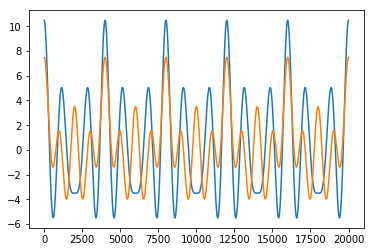

In [80]:
plt.plot(2*np.cos(5*pi*t) + 5*np.cos(15*pi*t) + 3*np.cos(20*pi*t) + noise)
plt.plot(2*np.cos(5*pi*t) + 2*np.cos(10*pi*t) + 3*np.cos(20*pi*t) + noise)

In [71]:
x = np.linspace(0, 100, num=1000)
x1 = np.linspace(0, 10, num=1000)
x2 = np.linspace(0, 1000, num=1000)

In [20]:
x

array([  0.        ,   0.1001001 ,   0.2002002 ,   0.3003003 ,
         0.4004004 ,   0.5005005 ,   0.6006006 ,   0.7007007 ,
         0.8008008 ,   0.9009009 ,   1.001001  ,   1.1011011 ,
         1.2012012 ,   1.3013013 ,   1.4014014 ,   1.5015015 ,
         1.6016016 ,   1.7017017 ,   1.8018018 ,   1.9019019 ,
         2.002002  ,   2.1021021 ,   2.2022022 ,   2.3023023 ,
         2.4024024 ,   2.5025025 ,   2.6026026 ,   2.7027027 ,
         2.8028028 ,   2.9029029 ,   3.003003  ,   3.1031031 ,
         3.2032032 ,   3.3033033 ,   3.4034034 ,   3.5035035 ,
         3.6036036 ,   3.7037037 ,   3.8038038 ,   3.9039039 ,
         4.004004  ,   4.1041041 ,   4.2042042 ,   4.3043043 ,
         4.4044044 ,   4.5045045 ,   4.6046046 ,   4.7047047 ,
         4.8048048 ,   4.9049049 ,   5.00500501,   5.10510511,
         5.20520521,   5.30530531,   5.40540541,   5.50550551,
         5.60560561,   5.70570571,   5.80580581,   5.90590591,
         6.00600601,   6.10610611,   6.20620621,   6.30

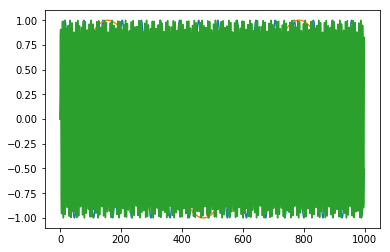

In [25]:
plt.plot(np.sin(x))
plt.plot(np.sin(x1))
plt.plot(np.sin(x2))